*   Analyzing the domain of sales and understanding customer behavior.
*   Performing the Exploratory Data Analysis based on the insights gained from domain knowledge.
*   Pre-Processing of the data to remove the outliers, imputing the data for missing values.
*   Scaling the data to normalize the values.
*   Considering the important features by reducing the dimensionality using PCA.
*   Using the Clustering technique to identify the segments of customers.
*   Quantum Enhancements (Comparing Algorithm on Classical vs Quantum) 

In [13]:
# Import the pandas library. More information: https://pandas.pydata.org/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the marketing campaign dataset
# Import the data as a pandas dataframe
cpa = pd.read_csv("/content/marketing_campaign.csv", sep="\t")

cpa.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [14]:
#overview of the attributes in the dataset
cpa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Only Income field has null values.

In [15]:
cpa['ID'].describe() #min value is zero, so all the data is positive. 

count     2240.000000
mean      5592.159821
std       3246.662198
min          0.000000
25%       2828.250000
50%       5458.500000
75%       8427.750000
max      11191.000000
Name: ID, dtype: float64

In [16]:
#replacing the income with mode.
mode = cpa['Income'].mode()[0]
cpa['Income'] = cpa['Income'].fillna(mode)
cpa['Income'].isna().sum() #checking the values

0

We will come across outliers, and we will remove them if they are less in number.

Now we are going to combine few columns into a single column

First getting into the family details :

-> Combine kidhome and teenhome to get the total number of children in the customer's household

-> Get the total headcount of the family

In [17]:
cpa['Kids'] = cpa['Kidhome'] + cpa['Teenhome']

#Deriving living situation by marital status Solo or Couple
cpa["Living_With"]=cpa["Marital_Status"].replace({"Married": 2, "Together": 2, "Absurd": 1, "Alone":1, "Widow": 1, "YOLO": 1, "Divorced": 1, "Single": 1,})

#Feature for total members in the householde
cpa["Family_headcount"] = cpa["Living_With"] + cpa['Kids']

#creating a feature pertaining parenthood
cpa["Is_Parent"] = np.where(cpa.Kids> 0, 1, 0)



<Figure size 576x576 with 0 Axes>

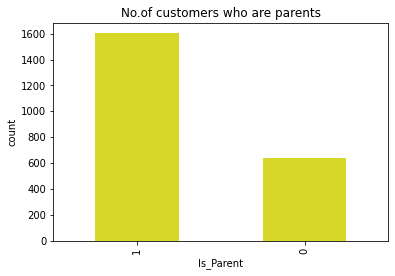

<Figure size 576x576 with 0 Axes>

In [18]:
cpa['Is_Parent'].value_counts().plot(kind='bar',color = '#d6d727')
plt.title("No.of customers who are parents",fontsize=12)
plt.ylabel("count")
plt.xlabel("Is_Parent")
plt.figure(figsize=(8,8))

**Lets** get the latest and oldest dates of customer's enrollement to get the span of this dataset

In [19]:
cpa['Dt_Customer'] = pd.to_datetime(cpa['Dt_Customer'])

cpa['Dt_Customer'].max(), cpa['Dt_Customer'].min()

(Timestamp('2014-12-06 00:00:00'), Timestamp('2012-01-08 00:00:00'))

The span is nearly 2 years.

Now lets go a little back in time so that we can get the details to be readable and makes much more sense.

We will assume that the customer information was collected 2014-12-07.

In [20]:
#calculating age based on Year of Birth
cpa['Age'] = 2014 - cpa['Year_Birth']

#Year_Birth is no longer required. So, dropping the column
cpa=cpa.drop(columns="Year_Birth")

#check the values in the new column
cpa['Age'].value_counts()

# data has outliers with age>100. setting the boundary as 100 replacing all values 100 where age is greater than 100
cpa['Age']= cpa['Age'].apply(lambda x: 100 if (x > 100) else x)


45.171875

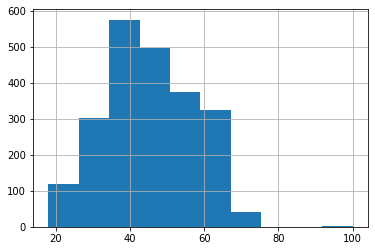

In [21]:


# Age Distribution
ax=cpa['Age'].hist()
cpa['Age'].mean()



In [22]:
cpa['Collected'] = '2014-12-07'
cpa['Collected'] = pd.to_datetime(cpa['Collected'])

cpa['Days_is_client'] = (cpa['Collected'] - cpa['Dt_Customer']).dt.days

Now going through the product and place details:

-> Get the total spending amount

-> Get the total number of purchases

-> Get Average Amount spent

-> Get the total share deals from the total number of purchases

-> Get the total number of accepted offers in all campaigns



In [23]:
cpa['MntTotal'] = cpa['MntWines']+cpa['MntFruits']+cpa['MntMeatProducts']+cpa['MntFishProducts']+cpa['MntSweetProducts']+cpa['MntGoldProds']

cpa['NumAllPurchases'] = cpa['NumWebPurchases']+cpa['NumCatalogPurchases']+cpa['NumStorePurchases']

cpa['AverageCheck'] = round((cpa['MntTotal'] / cpa['NumAllPurchases']), 1)

cpa['ShareDealsPurchases'] = round((cpa['NumDealsPurchases'] / cpa['NumAllPurchases']) * 100, 1)

cpa['TotalAcceptedCmp'] = cpa['AcceptedCmp1']+cpa['AcceptedCmp2']+cpa['AcceptedCmp3']+cpa['AcceptedCmp4']+cpa['AcceptedCmp5']+cpa['Response']

On checking the data we get to see that 6 customers have spent money but didn't make any purchase which makes no sense.

We are going to delete those six customers

Now our datacount will 2210

In [24]:
cpa = cpa.query("NumAllPurchases != 0")

{'boxes': [<matplotlib.lines.Line2D at 0x7f24253d8890>],
 'caps': [<matplotlib.lines.Line2D at 0x7f24253de910>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f24253e5950>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f24253e5410>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f24253d8e50>,
  <matplotlib.lines.Line2D at 0x7f24253de3d0>]}

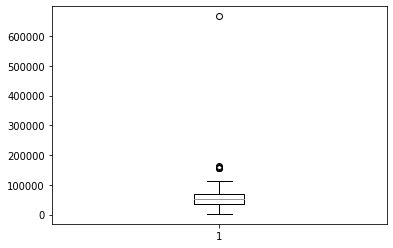

In [25]:
plt.boxplot(cpa['Income'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f242534c890>],
 'caps': [<matplotlib.lines.Line2D at 0x7f2425350910>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2425359950>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f2425359410>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f242534ce50>,
  <matplotlib.lines.Line2D at 0x7f24253503d0>]}

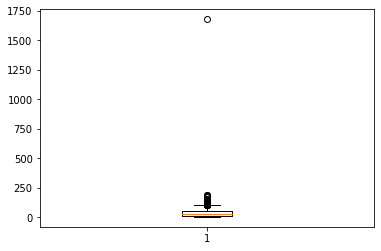

In [26]:
plt.boxplot(cpa['AverageCheck'])

Let's cover the outliers now

In [27]:
cpa['Income'] = np.where(cpa['Income'] > 120000, 120000, cpa['Income'])

cpa['AverageCheck'] = np.where(cpa['AverageCheck'] > 250, 250, cpa['AverageCheck'])

<Figure size 576x576 with 0 Axes>

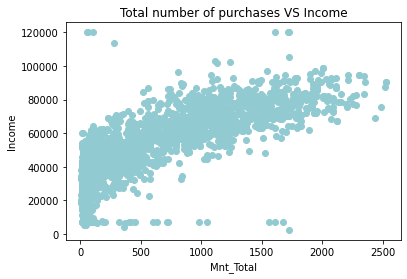

<Figure size 576x576 with 0 Axes>

In [28]:
# cpa['MntTotal'].value_counts().plot(kind='bar',color = '#d6d727')
plt.scatter(cpa['MntTotal'],cpa['Income'], color='#92cad1')
plt.title("Total number of purchases VS Income",fontsize=12)
plt.ylabel("Income")
plt.xlabel("Mnt_Total")
plt.figure(figsize=(8,8))

In [29]:
#Grouping education levels in to three categories
cpa["Education"]=cpa["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})


<Figure size 576x576 with 0 Axes>

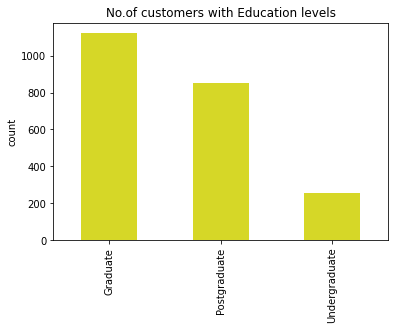

<Figure size 576x576 with 0 Axes>

In [30]:
cpa['Education'].value_counts().plot(kind='bar',color = '#d6d727')
plt.title("No.of customers with Education levels",fontsize=12)
plt.ylabel("count")
plt.figure(figsize=(8,8))

In [31]:
#Deriving living situation by marital status Solo or Couple
cpa["Living_With"]=cpa["Marital_Status"].replace({"Married": 2, "Together": 2, "Absurd": 1, "Alone":1, "Widow": 1, "YOLO": 1, "Divorced": 1, "Single": 1,})

#Marital status is no longer required. So, dropping the column
cpa=cpa.drop(columns="Marital_Status")


<Figure size 576x576 with 0 Axes>

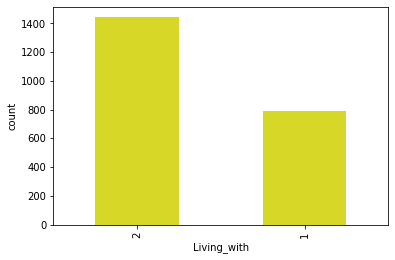

<Figure size 576x576 with 0 Axes>

In [32]:
cpa['Living_With'].value_counts().plot(kind='bar',color = '#d6d727')
plt.xlabel("Living_with")
plt.ylabel("count")
plt.figure(figsize=(8,8))

In [33]:
cpa

,ID,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Family_headcount,Is_Parent,Age,Collected,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,ShareDealsPurchases,TotalAcceptedCmp
0,5524,Graduate,58138.0,0,0,2012-04-09,58,635,88,546,...,1,0,57,2014-12-07,972,1617,22,73.5,13.6,1
1,2174,Graduate,46344.0,1,1,2014-08-03,38,11,1,6,...,3,1,60,2014-12-07,126,27,4,6.8,50.0,0
2,4141,Graduate,71613.0,0,0,2013-08-21,26,426,49,127,...,2,0,49,2014-12-07,473,776,20,38.8,5.0,0
3,6182,Graduate,26646.0,1,0,2014-10-02,26,11,4,20,...,3,1,30,2014-12-07,66,53,6,8.8,33.3,0
4,5324,Postgraduate,58293.0,1,0,2014-01-19,94,173,43,118,...,3,1,33,2014-12-07,322,422,14,30.1,35.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduate,61223.0,0,1,2013-06-13,46,709,43,182,...,3,1,47,2014-12-07,542,1341,16,83.8,12.5,0
2236,4001,Postgraduate,64014.0,2,1,2014-10-06,56,406,0,30,...,5,1,68,2014-12-07,62,444,15,29.6,46.7,1
2237,7270,Graduate,56981.0,0,0,2014-01-25,91,908,48,217,...,1,0,33,2014-12-07,316,1241,18,68.9,5.6,1
2238,8235,Postgraduate,69245.0,0,1,2014-01-24,8,428,30,214,...,3,1,58,2014-12-07,317,843,21,40.1,9.5,0


Let's cover the outliers now

In [34]:

#Segmenting education levels in to three groups
cpa["Education"]=cpa["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For better clarity
cpa=cpa.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Kidhome", "Teenhome", "Dt_Customer", "Z_CostContact", "Z_Revenue", "ID", "Collected"]

cpa = cpa.drop(to_drop, axis=1)

In [35]:
cpa.head()

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,...,Living_With,Family_headcount,Is_Parent,Age,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,ShareDealsPurchases,TotalAcceptedCmp
0,Graduate,58138.0,58,635,88,546,172,88,88,3,...,1,1,0,57,972,1617,22,73.5,13.6,1
1,Graduate,46344.0,38,11,1,6,2,1,6,2,...,1,3,1,60,126,27,4,6.8,50.0,0
2,Graduate,71613.0,26,426,49,127,111,21,42,1,...,2,2,0,49,473,776,20,38.8,5.0,0
3,Graduate,26646.0,26,11,4,20,10,3,5,2,...,2,3,1,30,66,53,6,8.8,33.3,0
4,Postgraduate,58293.0,94,173,43,118,46,27,15,5,...,2,3,1,33,322,422,14,30.1,35.7,0


We are going to preprocess the data to make the data available for PCA

Theese are the following steps will be applied to preprocess the data:

Ensure Label encoding will take place for the categorical features

Scale all the features using the standard scaler

Creating a copy of the subset dataframe for dimensionality reduction

In [36]:
#Listing the categorical variables
cpa_categorical = (cpa.dtypes == 'object')
object_cols = list(cpa_categorical[cpa_categorical].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education']


In [37]:
#Label Encoding the object dtypes.
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
for i in object_cols:
    cpa[i]=cpa[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [38]:
cpa_copy = cpa.copy()
cat_col =  [x for x in cpa_copy.columns if ((cpa_copy[x].dtype != 'int64') & (cpa_copy[x].dtype != 'float64'))]
cpa_copy=pd.get_dummies(cpa_copy , columns=cat_col , drop_first=True)

In [39]:
from sklearn.preprocessing import StandardScaler
num_cols =  [x for x in cpa_copy.columns if ~((cpa_copy[x].dtype != 'int64') & (cpa_copy[x].dtype != 'float64'))]
Scaler = StandardScaler()
cpa_copy[num_cols] = Scaler.fit_transform(cpa_copy[num_cols])

Now we have encoded and normalized the data which is ready for dimensionality reduction.

In [40]:
to_drop=["ShareDealsPurchases","AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5","NumDealsPurchases","NumWebVisitsMonth","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]
cpa_copy = cpa_copy.drop(to_drop, axis=1)

In [41]:
cpa_copy

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,Complain,...,Kids,Living_With,Family_headcount,Is_Parent,Age,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,TotalAcceptedCmp
0,-0.895637,0.315152,0.307582,0.981118,1.548633,1.676696,2.458536,1.473616,0.840633,-0.097413,...,-1.266783,-1.349336,-1.763961,-1.588603,0.997190,1.975431,1.676727,1.312465,1.182672,0.619279
1,-0.895637,-0.238887,-0.382905,-0.872661,-0.637518,-0.714752,-0.651775,-0.632720,-0.730909,-0.097413,...,1.395487,-1.349336,0.444945,0.629484,1.249947,-1.670576,-0.963936,-1.192963,-1.012574,-0.502756
2,-0.895637,0.948159,-0.797198,0.360221,0.568635,-0.178891,1.342483,-0.148505,-0.040964,-0.097413,...,-1.266783,0.741105,-0.659508,-1.588603,0.323169,-0.175110,0.279999,1.034084,0.040617,-0.502756
3,-0.895637,-1.164227,-0.797198,-0.872661,-0.562133,-0.652752,-0.505407,-0.584299,-0.750075,-0.097413,...,0.064352,0.741105,0.444945,0.629484,-1.277629,-1.929158,-0.920755,-0.914582,-0.946750,-0.502756
4,0.566975,0.322434,1.550459,-0.391391,0.417866,-0.218748,0.153247,-0.003240,-0.558423,-0.097413,...,0.064352,0.741105,0.444945,0.629484,-1.024872,-0.825875,-0.307922,0.198941,-0.245719,-0.502756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.895637,0.460074,-0.106710,1.200957,0.417866,0.064683,0.080063,2.199939,3.887892,-0.097413,...,0.064352,0.741105,0.444945,0.629484,0.154664,0.122259,1.218348,0.477322,1.521668,-0.502756
2236,0.566975,0.591185,0.238533,0.300805,-0.662646,-0.608466,-0.688367,-0.656931,-0.692579,-0.097413,...,2.726622,0.741105,2.653852,0.629484,1.923968,-1.946397,-0.271384,0.338132,-0.262175,0.619279
2237,-0.895637,0.260801,1.446886,1.792146,0.543506,0.219684,-0.102896,-0.366402,-0.385937,-0.097413,...,-1.266783,-1.349336,-1.763961,-1.588603,-1.024872,-0.851733,1.052268,0.755703,1.031276,0.619279
2238,0.566975,0.836919,-1.418636,0.366162,0.091199,0.206398,0.775309,0.069392,0.323174,-0.097413,...,0.064352,0.741105,0.444945,0.629484,1.081442,-0.847423,0.391272,1.173274,0.083403,-0.502756


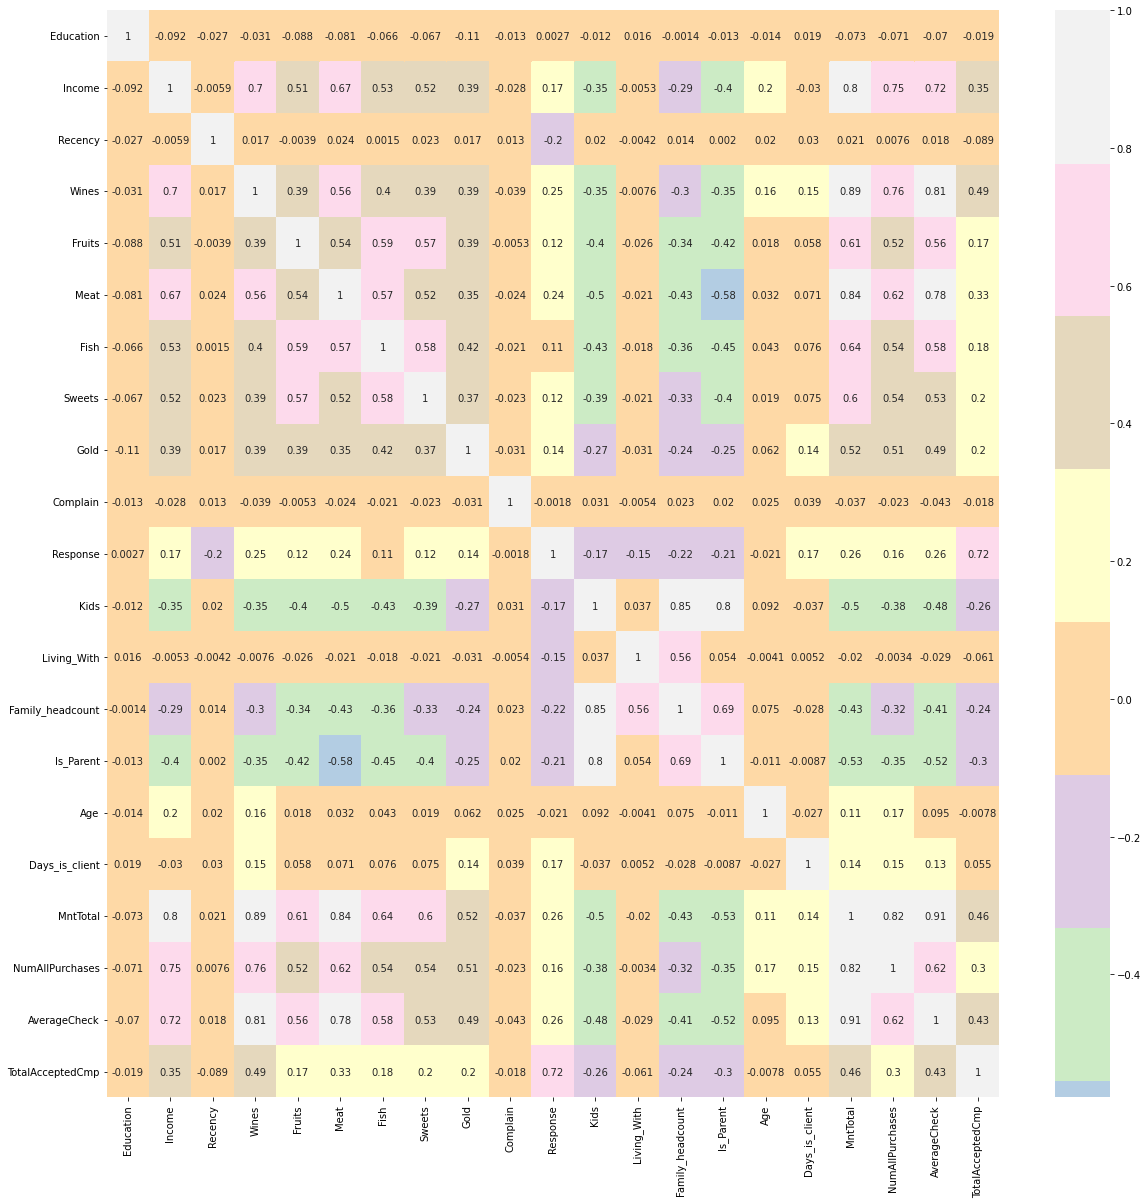

In [42]:
#Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib import colors
correlation_matrix= cpa_copy.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(correlation_matrix,annot=True, cmap='Pastel1', center=0) #generating the matrix

In [43]:
from matplotlib import pyplot as plot
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=9) 

#transform 
cpa_pca_transformed = pca.fit_transform(cpa_copy)

#converting to dataframe
cpa_pca= pd.DataFrame(data =  cpa_pca_transformed)

# print the component data
cpa_pca

,0,1,2,3,4,5,6,7,8
0,5.417107,1.220686,0.570403,0.985809,1.771860,-0.274615,-0.154868,0.559053,1.112169
1,-2.842886,0.017172,-0.117301,1.938791,-1.516920,-1.280632,0.258794,0.175525,-0.110812
2,1.871029,0.259253,-1.232528,-0.567078,-0.684208,-0.581873,0.595500,0.182159,1.447410
3,-2.758205,0.526205,-0.526148,-1.108033,-1.011221,-1.705406,0.298784,-0.694689,-0.383926
4,-0.700138,-0.608284,-1.112746,-0.694437,-0.087810,0.436180,-0.374154,-1.020476,-1.391861
...,...,...,...,...,...,...,...,...,...
2229,2.596346,-2.432068,-0.595744,0.072572,1.197349,-1.119874,-0.555543,0.621105,0.129591
2230,-2.029938,-3.292356,1.188136,0.788046,-2.550787,0.402729,0.373782,-0.295607,-0.756685
2231,2.623690,1.752493,-0.731591,1.146442,-0.369896,0.211806,-0.645855,-2.064752,-0.492396
2232,0.767909,-1.579229,-0.225018,-0.215320,-1.441778,-0.146184,0.564461,1.510723,0.106164


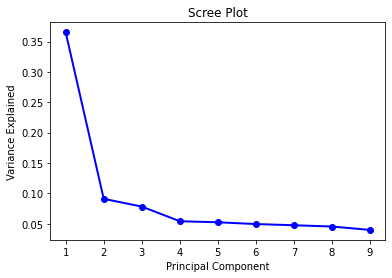

In [44]:
pca_values = np.arange(pca.n_components_) + 1
plot.plot(pca_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plot.title('Scree Plot')
plot.xlabel('Principal Component')
plot.ylabel('Variance Explained')
plot.show()


In [45]:

initial_feature_names = cpa_copy.columns

pca = PCA(n_components = 4)
pca.fit(cpa_copy)

n=pca.components_.shape[0]
reduced_df= pca.transform(cpa_copy)
most_important=[np.abs(pca.components_[i]).argmax() for i in range(n)]
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n)}
df = pd.DataFrame(sorted(dic.items()))




In [46]:
pca.explained_variance_ratio_

array([0.36525514, 0.09102783, 0.07827612, 0.05413904])

In [47]:
#converting to dataframe
cpa_pca= pd.DataFrame(data =  reduced_df, columns=(["col1","col2", "col3", "col4"]))

# print the component data
cpa_pca.head(5)

,col1,col2,col3,col4
0,5.417106,1.220717,0.570191,0.986178
1,-2.842886,0.017163,-0.117221,1.938667
2,1.871028,0.259184,-1.232719,-0.567671
3,-2.758205,0.526239,-0.526187,-1.107751
4,-0.700138,-0.608309,-1.112924,-0.694674


In [48]:
cpa_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2234.0,-7.305407e-17,2.770161,-4.123817,-2.381172,-0.830841,2.075484,8.053064
col2,2234.0,7.355103e-18,1.382910,-4.749346,-0.997260,0.012020,0.853181,4.773645
col3,2234.0,4.532334e-17,1.282394,-3.188054,-0.726390,-0.184639,0.399557,5.093287
col4,2234.0,-9.380242e-17,1.066504,-3.142687,-0.750904,-0.097166,0.779544,4.803174


In [49]:
cpa_copy.to_csv("/content/cpa_clean.csv", index = False, header=True)

Using the elbow to determine the number of clusters.

We can see that the elbow was not sure of 2 or 3 , but the silhouetter score determines that k = 2.

Elbow Method to determine the number of clusters to be formed:


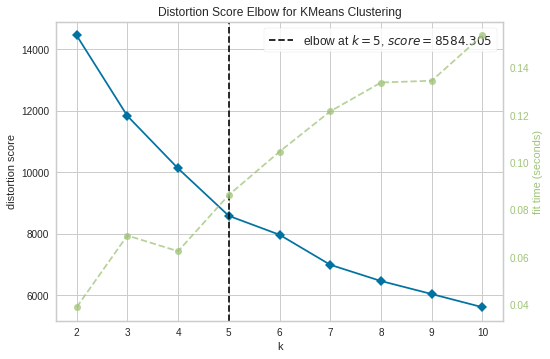

In [50]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(cpa_pca)
Elbow_M.show()

In [51]:
kmeans = KMeans(n_clusters=5 )    
kmeans.fit(cpa_copy)
cpa['Personality']=kmeans.labels_
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


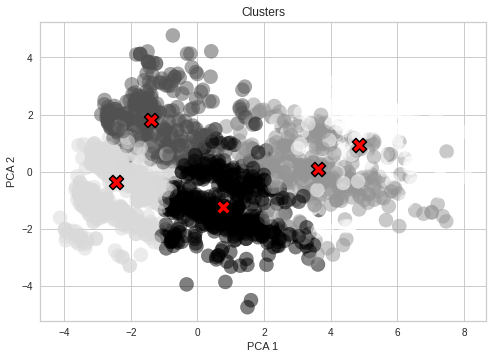

In [52]:
x = cpa_pca.iloc[:, 0]
y = cpa_pca.iloc[:, 1]

plt.scatter(x, y, c=kmeans.labels_, alpha=0.5, s=200)  # plot different colors per cluster
plt.title('Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.scatter(centroids_pca[:,0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)

plt.show()

Text(0, 0.5, 'PC2')

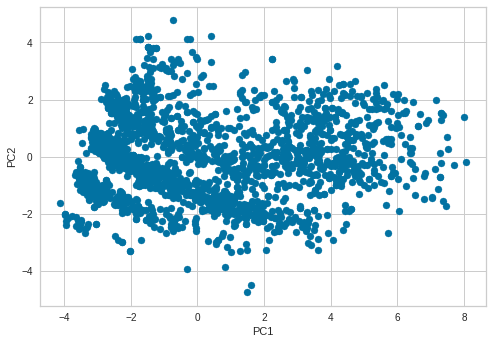

In [53]:
plot.scatter(cpa_pca.iloc[:,0], cpa_pca.iloc[:,1])
plot.xlabel("PC1")
plot.ylabel("PC2")

**What is the percentage of each cluster ?**

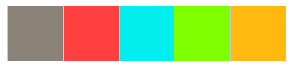

In [54]:
colors_nude = ['#8B8378','#FF4040','#00EEEE','#7FFF00','#FFB90F']
sns.palplot(sns.color_palette(colors_nude))
# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

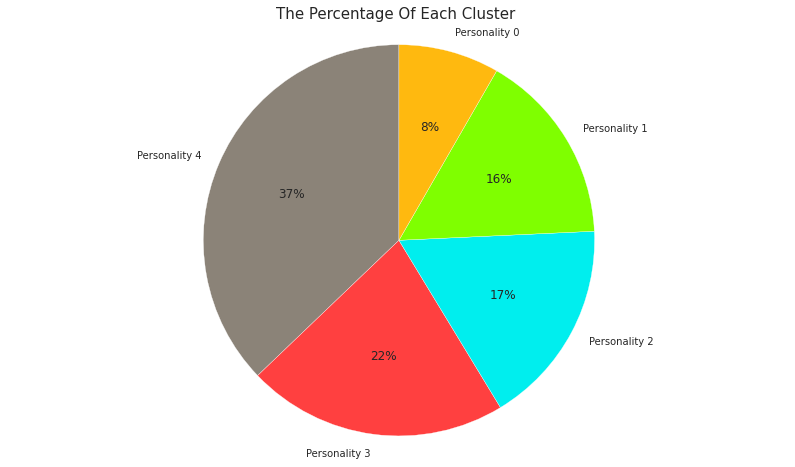

In [55]:

plt.figure(figsize = (14,8) )
plt.pie(list(cpa['Personality'].value_counts()),labels=['Personality 4' ,'Personality 3', 'Personality 2', 'Personality 1' , 'Personality 0'],
        autopct='%.00f%%' ,colors=colors_nude, startangle=90  , explode = None)
plt.title('The Percentage Of Each Cluster ' ,fontsize = 15)
plt.axis('equal')
plt.show()

**What is the Age Distribution of each cluster ?**

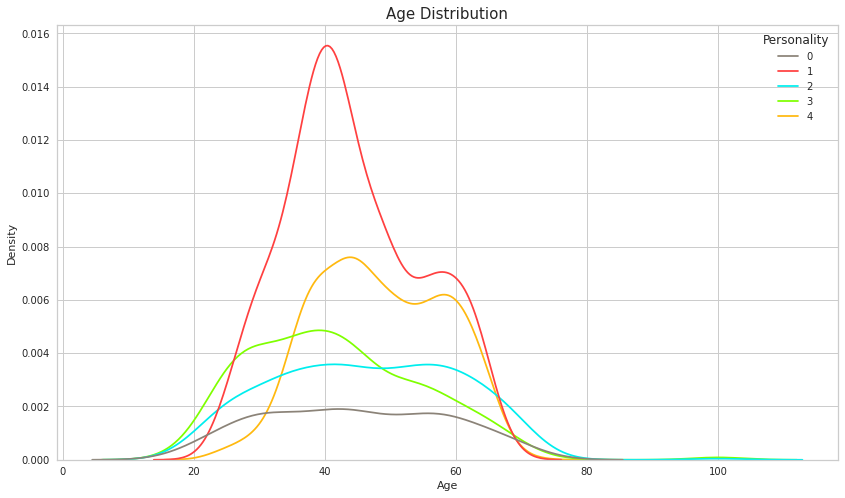

In [56]:
plt.figure(figsize = (14,8) )
sns.kdeplot(data =cpa, x = 'Age' , hue = 'Personality' , palette=colors_nude[:5])
plt.title('Age Distribution' ,fontsize = 15)
plt.show()

In [57]:
cluster0 = cpa[(cpa['Age'] > 40 )&(cpa['Personality'] == 0)]
cluster1 = cpa[(cpa['Age'] > 40 )&(cpa['Personality'] == 1)]
cluster2 = cpa[(cpa['Age'] > 40 )&(cpa['Personality'] == 2)]
cluster3 = cpa[(cpa['Age'] > 40 )&(cpa['Personality'] == 3)]
cluster4 = cpa[(cpa['Age'] > 40 )&(cpa['Personality'] == 4)]
print('percentage of customer more than 40 at cluster0 : {0:0.2f}%'.format(len(cluster0) / len(cpa[cpa['Personality'] == 0] )))
print('percentage of customer more than 40 at cluster1 : {0:0.2f}%'.format(len(cluster1) / len(cpa[cpa['Personality'] == 1])))
print('percentage of customer more than 40 at cluster1 : {0:0.2f}%'.format(len(cluster2) / len(cpa[cpa['Personality'] == 1])))
print('percentage of customer more than 40 at cluster1 : {0:0.2f}%'.format(len(cluster3) / len(cpa[cpa['Personality'] == 1])))
print('percentage of customer more than 40 at cluster1 : {0:0.2f}%'.format(len(cluster4) / len(cpa[cpa['Personality'] == 1])))

percentage of customer more than 40 at cluster0 : 0.60%
percentage of customer more than 40 at cluster1 : 0.60%
percentage of customer more than 40 at cluster1 : 0.27%
percentage of customer more than 40 at cluster1 : 0.23%
percentage of customer more than 40 at cluster1 : 0.44%


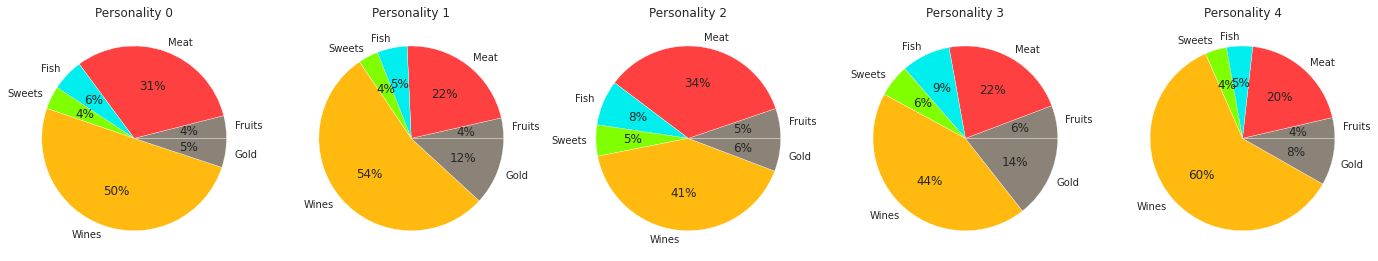

In [59]:
plt.figure(figsize = (24,12) )
labels=['Fruits','Meat','Fish','Sweets','Wines','Gold']
for i in range(5):
    counts =[]
    _cpa = cpa[cpa['Personality'] == i]
    counts.append(_cpa['Fruits'].sum())
    counts.append(_cpa['Meat'].sum())    
    counts.append(_cpa['Fish'].sum())    
    counts.append(_cpa['Sweets'].sum())    
    counts.append(_cpa['Wines'].sum())
    counts.append(_cpa['Gold'].sum())
    plt.subplot(1,5,i+1)
    plt.title("Personality "+str(i))
    plt.pie(counts,labels=labels,  autopct='%.0f%%' ,colors=colors_nude)
plt.show()

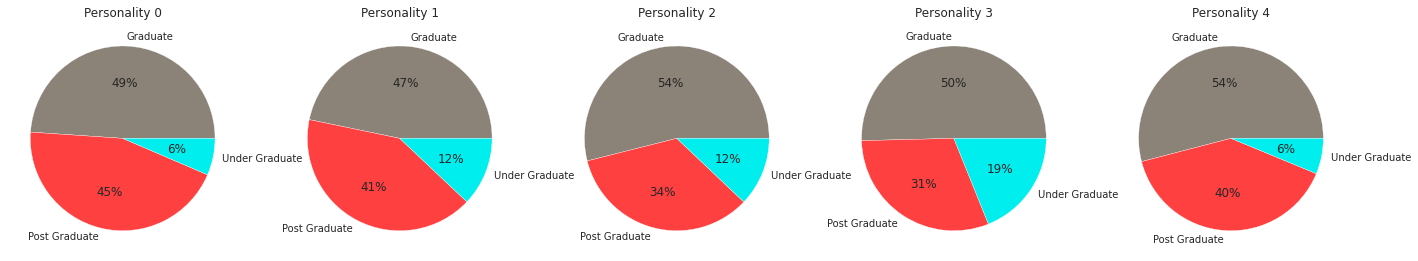

In [60]:
plt.figure(figsize = (24,8) )
education =['Graduate', 'Post Graduate', 'Under Graduate']
for i in range(5):
    counts =[]
    _cpa_education = cpa[cpa['Personality'] == i]
    counts.append(len(_cpa_education[_cpa_education['Education'] == 0]))
    counts.append(len(_cpa_education[_cpa_education['Education'] == 1]))    
    counts.append(len(_cpa_education[_cpa_education['Education'] == 2]))    
    plt.subplot(1,5,i+1)
    plt.title("Personality "+str(i))
    plt.pie(counts, labels=education,autopct='%.0f%%' ,colors=colors_nude)
plt.show()

In [61]:
cpa.groupby(['Personality'])['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Personality,,,,,,,,
0,186.0,77607.817204,13036.133632,7500.0,71620.50,79531.5,85453.25,105471.0
1,830.0,38048.012048,13881.424500,5305.0,29032.50,38012.5,46453.00,120000.0
2,356.0,74327.213483,12396.542852,7500.0,68675.75,74951.5,81080.25,120000.0
3,381.0,33833.244094,13748.629309,6560.0,23529.00,32303.0,43322.00,73395.0
4,481.0,61386.900208,11758.644738,2447.0,55759.00,62335.0,68118.00,93404.0


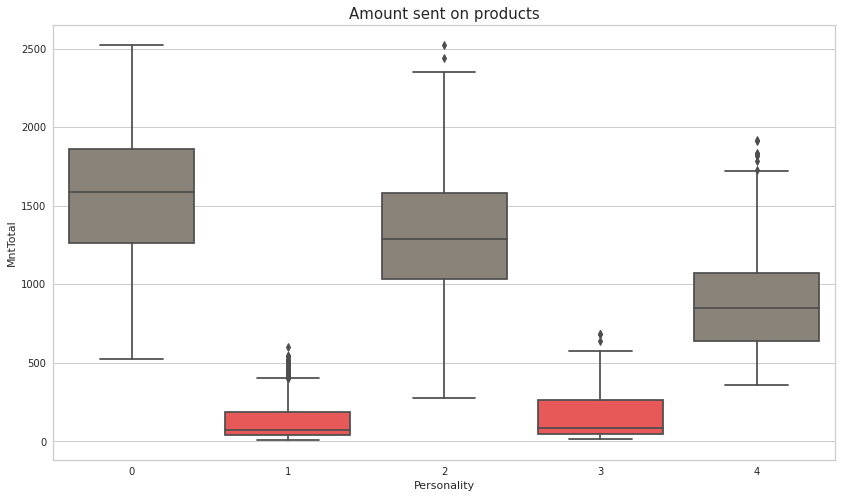

In [62]:
plt.figure(figsize = (14,8) )
sns.boxplot(data =cpa, x = 'Personality' , y = 'MntTotal' ,palette=colors_nude[:2])
plt.title('Amount sent on products' ,fontsize = 15)
plt.show()

In [63]:
cpa_quantum = pd.read_csv("/content/cpa_clean.csv")
cpa_quantum

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,Complain,...,Kids,Living_With,Family_headcount,Is_Parent,Age,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,TotalAcceptedCmp
0,-0.895637,0.315152,0.307582,0.981118,1.548633,1.676696,2.458536,1.473616,0.840633,-0.097413,...,-1.266783,-1.349336,-1.763961,-1.588603,0.997190,1.975431,1.676727,1.312465,1.182672,0.619279
1,-0.895637,-0.238887,-0.382905,-0.872661,-0.637518,-0.714752,-0.651775,-0.632720,-0.730909,-0.097413,...,1.395487,-1.349336,0.444945,0.629484,1.249947,-1.670576,-0.963936,-1.192963,-1.012574,-0.502756
2,-0.895637,0.948159,-0.797198,0.360221,0.568635,-0.178891,1.342483,-0.148505,-0.040964,-0.097413,...,-1.266783,0.741105,-0.659508,-1.588603,0.323169,-0.175110,0.279999,1.034084,0.040617,-0.502756
3,-0.895637,-1.164227,-0.797198,-0.872661,-0.562133,-0.652752,-0.505407,-0.584299,-0.750075,-0.097413,...,0.064352,0.741105,0.444945,0.629484,-1.277629,-1.929158,-0.920755,-0.914582,-0.946750,-0.502756
4,0.566975,0.322434,1.550459,-0.391391,0.417866,-0.218748,0.153247,-0.003240,-0.558423,-0.097413,...,0.064352,0.741105,0.444945,0.629484,-1.024872,-0.825875,-0.307922,0.198941,-0.245719,-0.502756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,-0.895637,0.460074,-0.106710,1.200957,0.417866,0.064683,0.080063,2.199939,3.887892,-0.097413,...,0.064352,0.741105,0.444945,0.629484,0.154664,0.122259,1.218348,0.477322,1.521668,-0.502756
2230,0.566975,0.591185,0.238533,0.300805,-0.662646,-0.608466,-0.688367,-0.656931,-0.692579,-0.097413,...,2.726622,0.741105,2.653852,0.629484,1.923968,-1.946397,-0.271384,0.338132,-0.262175,0.619279
2231,-0.895637,0.260801,1.446886,1.792146,0.543506,0.219684,-0.102896,-0.366402,-0.385937,-0.097413,...,-1.266783,-1.349336,-1.763961,-1.588603,-1.024872,-0.851733,1.052268,0.755703,1.031276,0.619279
2232,0.566975,0.836919,-1.418636,0.366162,0.091199,0.206398,0.775309,0.069392,0.323174,-0.097413,...,0.064352,0.741105,0.444945,0.629484,1.081442,-0.847423,0.391272,1.173274,0.083403,-0.502756


In [ ]:
k=3

n= cpa_quantum.shape[0]
n
c=cpa_quantum.shape[1]
c

21

In [64]:
#install the libraries
!pip install qcware

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 2.3 MB/s 
     |████████████████████████████████| 1.1 MB 29.7 MB/s 
     |████████████████████████████████| 188 kB 45.1 MB/s 
     |████████████████████████████████| 57 kB 4.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 44.7 MB/s 
     |████████████████████████████████| 232 kB 59.1 MB/s 
     |████████████████████████████████| 11.1 MB 41.6 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 64.0 MB/s 
     |████████████████████████████████| 144 kB 69.1 MB/s 
     |████████████████████████████████| 51 kB 5.5 MB/s 
  Created wheel for icontract: filename=icontract-2.6.1-py3-none-any.whl size=41341 sha256=fa72c3399ebff5b935d5690c1a72d61408edb2610f82f1c7984ff3919ff1463b
  Stored in directory: /root/.cache/pip/wheels/b5/85/62/de

In [68]:
from qcware.forge.qml import QMeans
from qcware import forge
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# this line is for internal tracking; it is not necessary for use!
# forge.config.set_environment_source_file('clustering.ipynb')

# Paste your API key below if not using Forge hosted notebooks
forge.config.set_api_key('F7g5kY9IgYulXkdz')

In [69]:
few=cpa_copy[['Income','MntTotal']]
few.head(100)

,Income,MntTotal
0,0.315152,1.676727
1,-0.238887,-0.963936
2,0.948159,0.279999
3,-1.164227,-0.920755
4,0.322434,-0.307922
...,...,...
95,-1.002159,-0.934041
96,-0.165040,-0.002336
97,0.018027,-0.904147
98,1.271544,0.615480


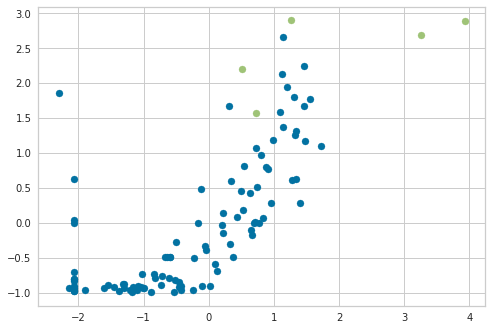

In [70]:
N_CLUSTERS, CLUSTER_SPREAD, DIMENSION = 5, 4, 2

cluster_centers = np.random.random((N_CLUSTERS, DIMENSION)) * CLUSTER_SPREAD
points =  few.head(100).to_numpy()
points
plt.scatter(points[:,0], points[:,1])

plt.scatter(cluster_centers[:,0], cluster_centers[:,1])

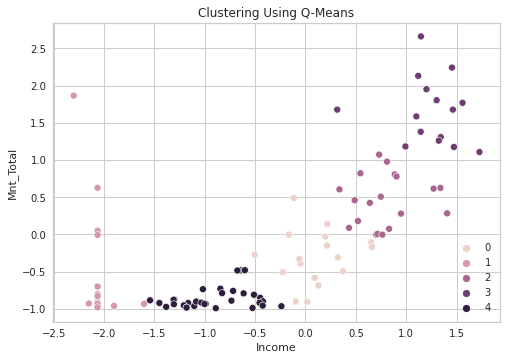

In [71]:
import seaborn as sns

# plt.scatter(points[:,0], points[:,1], c=qlabels)
# qlabels

#implement QMeans
qmeans = QMeans(n_clusters=N_CLUSTERS,backend='qcware/gpu_simulator')
qmeans.fit(points)
qlabels = qmeans.predict(points)

#plot the clusters
sns.scatterplot(data=points, x=points[:,0], y=points[:,1], hue=qlabels)
plt.legend()
plt.title("Clustering Using Q-Means")
plt.xlabel("Income")
plt.ylabel("Mnt_Total")
plt.show()

In [72]:
#cluster counts of QMeans
clusterCount = np.bincount(qlabels)
clusterCount

array([17, 16, 19, 15, 33])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


0     2
1     3
2     0
3     1
4     0
     ..
95    3
96    0
97    3
98    0
99    3
Name: Personality, Length: 100, dtype: int32

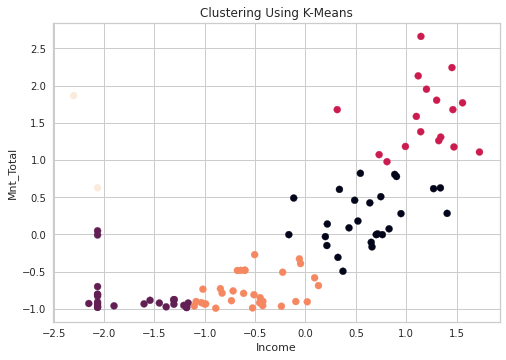

In [76]:
from sklearn.cluster import  KMeans
clusters = KMeans(n_clusters=5).fit(points)
new =few.head(100)
new["Personality"]= clusters.labels_
plt.scatter(points[:,0], points[:,1], c=new["Personality"])
plt.title("Clustering Using K-Means")
plt.xlabel("Income")
plt.ylabel("Mnt_Total")
new["Personality"]

In [77]:
#cluster counts of K-Means
clusterCount = np.bincount(new["Personality"])
clusterCount

array([26, 24, 17, 31,  2])